In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from rasterio.mask import mask
import geopandas as gpd
from datetime import datetime
import pandas as pd
from inundation_model_utils import ThresholdingModel, GroundTruthMeasurement
import warnings
from shapely.geometry import box
from rasterio.features import geometry_mask

class MyGroundTruthMeasurement(GroundTruthMeasurement):
  pass

import hydromt  # noqa: E402
import xarray as xr  # noqa: E402


In [2]:
def tif_to_clipped_masked_array(tif_path: str, geojson_path: str) -> tuple[np.ma.MaskedArray, rasterio.Affine, rasterio.crs.CRS]:
    """
    Clip a binary TIFF with a polygon from a GeoJSON file
    and return it as a masked array of True/False (wet/dry),
    with everything outside the polygon masked.

    Args:
        tif_path: Path to the .tif file.
        geojson_path: Path to the polygon (GeoJSON or shapefile).

    Returns:
        Tuple of:
            - np.ma.MaskedArray of clipped region (True=wet, False=dry)
            - Affine transform of the clipped raster
            - CRS of the raster
    """
    # Load polygon
    gdf = gpd.read_file(geojson_path)
    if gdf.crs is None:
        raise ValueError("Input GeoJSON has no CRS.")

    with rasterio.open(tif_path) as src:
        if src.crs is None:
            raise ValueError("Input TIFF has no CRS.")
        if src.crs.to_epsg() != 4326:
            raise ValueError(f"Input TIFF must be in EPSG:4326, found {src.crs}")
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Crop to bounding box first
        minx, miny, maxx, maxy = gdf.total_bounds
        bbox_geom = [box(minx, miny, maxx, maxy).__geo_interface__]
        clipped_data, clipped_transform = mask(src, bbox_geom, crop=True)
        data = clipped_data[0]

        # Mask everything outside the polygon
        polygon_mask = geometry_mask(
            geometries=gdf.geometry,
            out_shape=data.shape,
            transform=clipped_transform,
            invert=True  # True inside polygon
        )

        # Convert binary 1/0 to True/False
        binary_mask = (data == 1)

        # Apply polygon mask: everything outside polygon is masked
        masked_array = np.ma.masked_array(binary_mask, mask=~polygon_mask)

    return masked_array, clipped_transform, src.crs

def tif_to_clipped_array(tif_path: str, geojson_path: str) -> tuple[np.ndarray, rasterio.Affine, rasterio.crs.CRS]:
    """
    Clip DEM to the bounding box of the AOI but set everything outside the AOI polygon to NaN.
    Returns a numpy array (DEM values) with NaNs where data are outside the polygon.
    """
    gdf = gpd.read_file(geojson_path)

    with rasterio.open(tif_path) as src:
        if gdf.crs is None:
            raise ValueError("Input GeoJSON has no CRS.")
        if src.crs is None:
            raise ValueError("Input TIFF has no CRS.")
        if src.crs.to_epsg() != 4326:
            raise ValueError(f"Input TIFF must be in EPSG:4326, found {src.crs}")
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Get the bounding box geometry (still needed to crop to a small raster)
        minx, miny, maxx, maxy = gdf.total_bounds
        bbox_geom = [box(minx, miny, maxx, maxy).__geo_interface__]

        # Crop the DEM to the bounding box area
        clipped_data, clipped_transform = mask(src, bbox_geom, crop=True, filled=True, nodata=np.nan)
        data = clipped_data[0]

        # Now create a polygon mask (True inside polygon, False outside)
        from rasterio.features import geometry_mask
        polygon_mask = geometry_mask(
            geometries=gdf.geometry,
            out_shape=data.shape,
            transform=clipped_transform,
            invert=True  # True inside polygon
        )

        # Set everything outside polygon to NaN
        data = np.where(polygon_mask, data, np.nan)

    return data, clipped_transform, src.crs


# Function to find closest valid value
def find_closest_valid(df, dt, station):
    # Compute absolute difference
    df["diff"] = (df["datetime"] - dt).abs()

    # Sort by time difference
    df_sorted = df.sort_values("diff")

    # Iterate to find first non -999 value
    for idx, row in df_sorted.iterrows():
        value = row[station]
        if value != -999:
            time_diff = row["datetime"] - dt
            abs_diff = abs(time_diff)

            # Check thresholds
            if abs_diff > pd.Timedelta(days=1):
                raise ValueError(
                    f"Closest valid obs for {station} is {abs_diff} away "
                    f"(at {row['datetime']}). Image timestamp: {dt}"
                )
            elif abs_diff > pd.Timedelta(hours=5):
                warnings.warn(
                    f"Closest valid obs for {station} is {abs_diff} away "
                    f"(at {row['datetime']}). Image timestamp: {dt}"
                )

            if idx != df_sorted.index[0]:
                print("Closest timestamp initially had -999, using next closest valid value.")
            return row["datetime"], value

    # If all values are -999
    return None, None


In [3]:
aoi_name = "Samac"

images_dir = R"p:\11211461-010--eo-flood-ops\Sava\classified_events"

aoi_fn = os.path.join(
    R"p:\11211461-010--eo-flood-ops\Sava\AOI",
    f"AOI_{aoi_name}.geojson"
)
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\Sava\water_levels\Sava_Bosna_gauges_H_20190101_20250430.csv"

dem_fn = R"p:\11211461-010--eo-flood-ops\Sava\DEMs\bosna_FABDEM.tif"

In [4]:
# Store image paths and water levels
image_water_levels = []

# Variable to check if any images were processed
datetime_str = None

# find the water level measurement closest to the image timestamp and store it the corresponding image path
for image_name in os.listdir(images_dir):
    if not image_name.endswith(".tif"):
        continue  # Skip non-TIF files
    datetime_str = image_name.split("_")[1].replace(".tif", "") 
    dt = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
    dt = pd.Timestamp(dt)
    # Convert to GMT+1
    dt_gmt1 = dt + pd.Timedelta(hours=1)  

    df = pd.read_csv(waterlevels_fn, skiprows=[1])
    df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    station = aoi_name
    closest_time, value = find_closest_valid(df, dt_gmt1, station)
    
    if closest_time is not None:
        print(f"Image: {image_name}")  
        print("Closest valid timestamp:", closest_time)
        print(f"{station} value:", value)
        print("=" * 45)
        #image_path = os.path.join(images_dir, image_name)
        image_water_levels.append((image_name, value))
    else:
        print(f"No valid {station} values found in dataset.")
    
if datetime_str is None:
    raise ValueError("No images found in the specified directory.")

# Sort the list by water level (ascending) as required by the algorithm
image_water_levels.sort(key=lambda x: x[1])

Image: Bosna_20190204T164100.tif
Closest valid timestamp: 2019-02-04 18:00:00
Samac value: 8.14
Image: Bosna_20211107T045415.tif
Closest valid timestamp: 2021-11-07 06:00:00
Samac value: 5.22


In [5]:
GROUND_TRUTH = []
for image_name, water_level in image_water_levels:
    masked_array, transforms, crs = tif_to_clipped_masked_array(
        os.path.join(images_dir, image_name),
        aoi_fn,
    )
    GROUND_TRUTH.append(MyGroundTruthMeasurement(
        ground_truth=masked_array,
        gauge_measurement=water_level
    )
    )

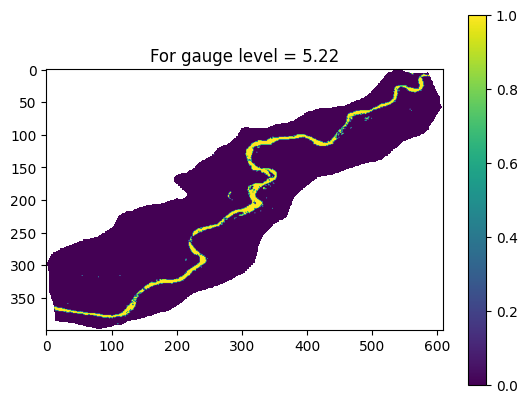

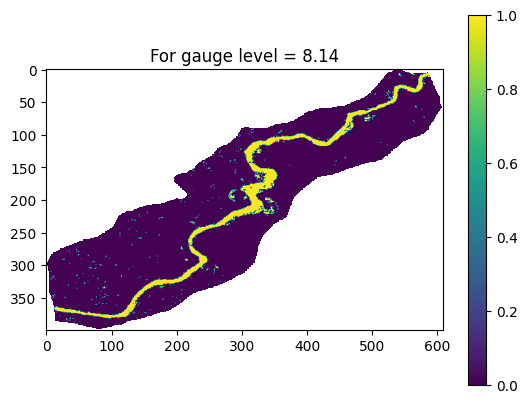

In [6]:
for gt in GROUND_TRUTH:
    plt.imshow(gt.ground_truth)
    plt.colorbar()
    plt.title(f'For gauge level = {gt.gauge_measurement}')
    plt.show()

In [7]:
# TRAINING THE MODEL
tm = ThresholdingModel()
# typical min ratio values to try
MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]

tm.train(
    minumum_ratios=MIN_RATIOS,
    ground_truth=GROUND_TRUTH
    )

For min_ratio=0.1 we get f1=0.993717033819423
For min_ratio=0.3 we get f1=0.993717033819423
For min_ratio=0.5 we get f1=0.993717033819423
For min_ratio=1 we get f1=0.993717033819423
For min_ratio=2 we get f1=0.9936370777690496
For min_ratio=5 we get f1=0.9936370777690496
For min_ratio=10 we get f1=0.9936370777690496
For min_ratio=15 we get f1=0.9936370777690496
For min_ratio=20 we get f1=0.9936370777690496
chosen min_ratio 1


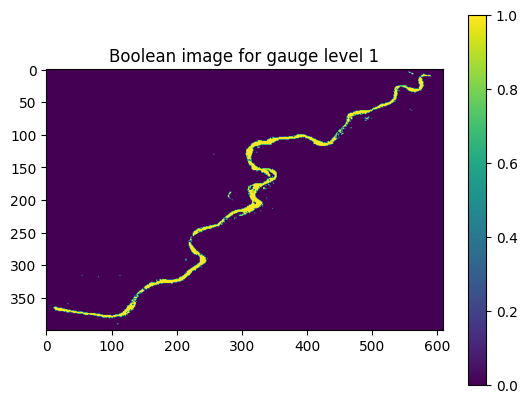

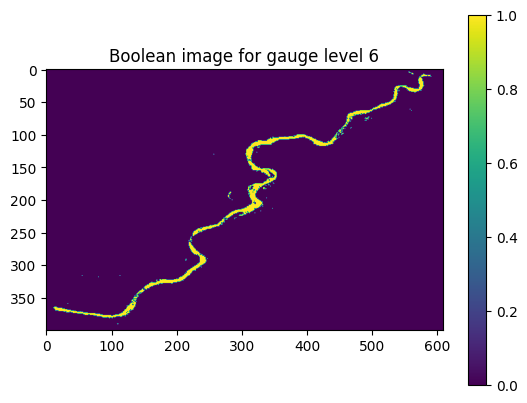

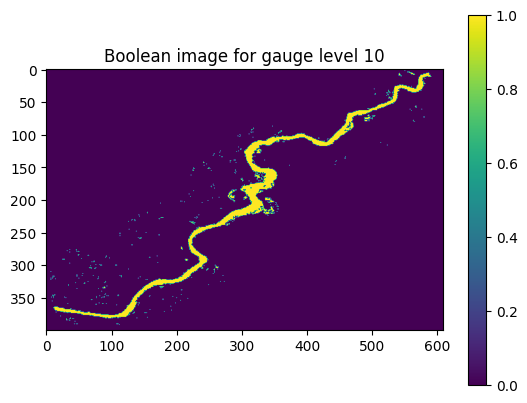

In [8]:
# example use of the model with infer (3 water levels)
for gauge_level in [1, 6, 10]:
    plt.title(f'Boolean image for gauge level {gauge_level}')
    plt.imshow(tm.infer(gauge_level))
    plt.colorbar()
    plt.show()

In [9]:
# function to generate a CF-compliant xarray Dataset of wet/dry masks or water depths for a time series of water levels 
# this includes a lat/lon grid and a water_level coordinate along time

def generate_wet_dry_timeseries_ds(water_levels, timestamps, tm, transform, crs):
    """
    Generate a CF-compliant xarray Dataset of wet/dry masks (boolean) or
    water depths (float) for a time series of water levels using a trained model.
    Includes water_level as a coordinate.

    Args:
        water_levels (list or array): Water levels to infer wet/dry masks or depths.
        timestamps (list or pd.DatetimeIndex): Corresponding timestamps.
        tm: Trained model with method tm.infer(level).
            - Returns boolean arrays for thresholding models.
            - Returns masked float arrays for manifold models.
        transform (Affine): Rasterio affine transform of the raster.
        crs (rasterio.crs.CRS): CRS of the raster (must be EPSG:4326).

    Returns:
        xr.Dataset: CF-compliant Dataset with dimensions (time, lat, lon)
    """
    def array_to_da(array, is_bool):
        """Convert boolean/float/masked array to xarray.DataArray with lat/lon."""
        if not isinstance(array, np.ma.MaskedArray):
            masked = np.ma.masked_array(array)
        else:
            masked = array

        nrows, ncols = masked.shape
        xs = np.arange(ncols)
        ys = np.arange(nrows)
        lon, _ = rasterio.transform.xy(transform, 0, xs, offset="center")
        _, lat = rasterio.transform.xy(transform, ys, 0, offset="center")
        lon = np.array(lon)
        lat = np.array(lat)

        # Ensure latitude is sorted ascending
        if lat[0] > lat[-1]:
            lat = lat[::-1]
            masked = masked[::-1, :]

        # Convert data
        if is_bool:
            data = masked.astype(np.float32)  # True/False → 1.0/0.0
        else:
            data = masked.filled(np.nan).astype(np.float32)

        da = xr.DataArray(
            data,
            dims=("lat", "lon"),
            coords={"lat": lat, "lon": lon},
        )

        if is_bool:
            da.attrs.update({"long_name": "wet_dry_mask", "units": "1"})
        else:
            da.attrs.update({"long_name": "water_depth", "units": "m"})

        da.attrs["grid_mapping"] = "spatial_ref"
        return da

    # Detect model type (boolean vs float)
    test_out = tm.infer(water_levels[0])
    is_bool = np.issubdtype(test_out.dtype, np.bool_)

    arrays = []
    for lvl in water_levels:
        arr = tm.infer(lvl)
        da = array_to_da(arr, is_bool)
        arrays.append(da)

    # Stack along time
    varname = "wet_dry" if is_bool else "water_depth"
    ts_da = xr.concat(arrays, dim=pd.Index(timestamps, name="time"))

    # Build Dataset
    ds = xr.Dataset({varname: ts_da})

    # Add water_level as coordinate along time
    ds = ds.assign_coords({"water_level": ("time", water_levels)})
    ds["water_level"].attrs.update({"long_name": "water_level", "units": "m"})

    # Add CF-compliant spatial_ref
    ds["spatial_ref"] = xr.DataArray(
        0,
        attrs={
            "spatial_ref": crs.to_wkt(),
            "grid_mapping_name": "latitude_longitude",
            "longitude_of_prime_meridian": 0.0,
            "semi_major_axis": 6378137.0,
            "inverse_flattening": 298.257223563,
        },
    )
    ds[varname].attrs["grid_mapping"] = "spatial_ref"

    # Coordinate metadata
    ds["lat"].attrs.update({"standard_name": "latitude", "units": "degrees_north"})
    ds["lon"].attrs.update({"standard_name": "longitude", "units": "degrees_east"})

    return ds

In [10]:
# example use of the function to generate a time series dataset
gauge_levels = [1, 6, 7.5, 3.2, 10]
timestamps = pd.date_range("2020-01-01", periods=len(gauge_levels), freq="7D")

ds = generate_wet_dry_timeseries_ds(gauge_levels, timestamps, tm, transforms, crs)
ds


<xarray.Dataset> Size: 5MB
Dimensions:      (lat: 400, lon: 609, time: 5)
Coordinates:
  * lat          (lat) float64 3kB 44.96 44.96 44.96 44.96 ... 45.07 45.07 45.07
  * lon          (lon) float64 5kB 18.3 18.3 18.3 18.3 ... 18.46 18.46 18.46
  * time         (time) datetime64[ns] 40B 2020-01-01 2020-01-08 ... 2020-01-29
    water_level  (time) float64 40B 1.0 6.0 7.5 3.2 10.0
Data variables:
    wet_dry      (time, lat, lon) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    spatial_ref  int32 4B 0

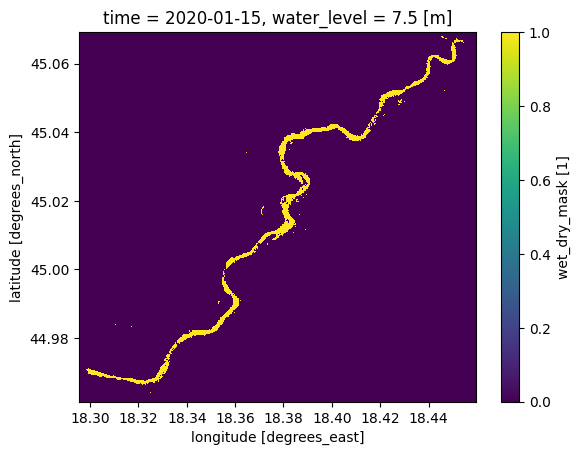

In [11]:
ds["wet_dry"].sel(time="2020-01-15").plot()

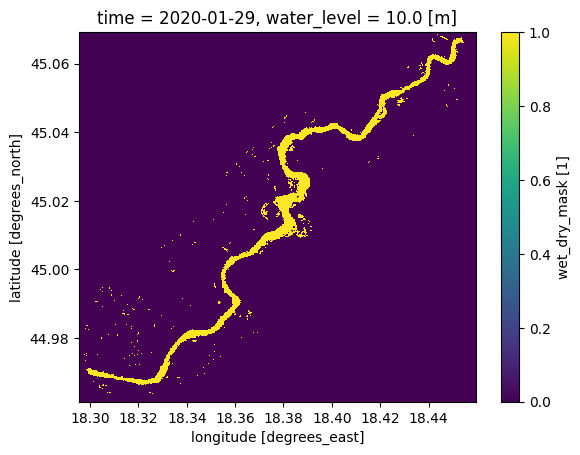

In [12]:
# example of plotting the wet/dry mask for the time with the highest water level
ds["wet_dry"].isel(time=ds["water_level"].argmax().item()).plot()

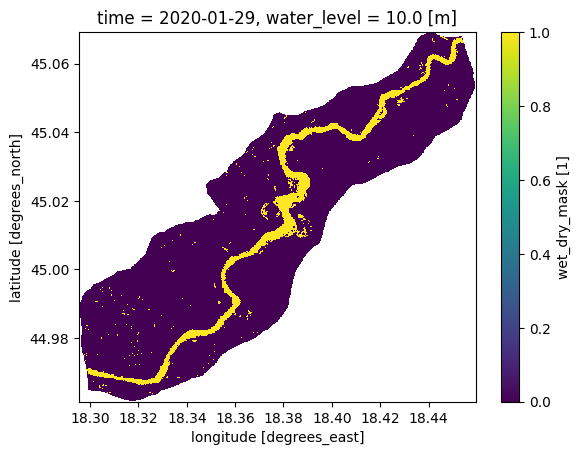

In [13]:
river_mask = gpd.read_file(aoi_fn)

ds_masked = ds.where(ds.raster.geometry_mask(river_mask, all_touched=False))
ds_masked["wet_dry"].isel(time=ds_masked["water_level"].argmax().item()).drop_vars("spatial_ref").plot()

### Manifold 

(400, 609)

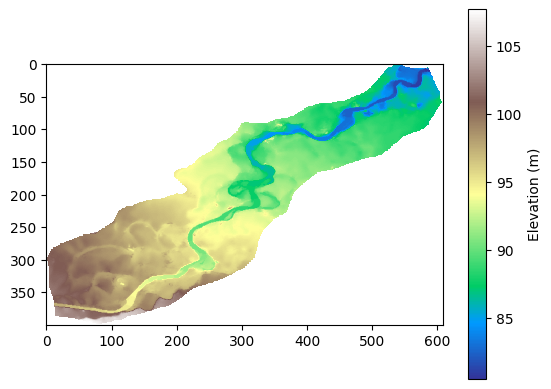

In [14]:
DEM, dem_transform, dem_crs = tif_to_clipped_array(dem_fn, aoi_fn)
plt.imshow(DEM, cmap='terrain')
plt.colorbar(label='Elevation (m)')
DEM.shape

In [16]:
from inundation_model_utils import flood_extent_to_depth_solve, LaplaceDepthSolverConfig, ManifoldModel

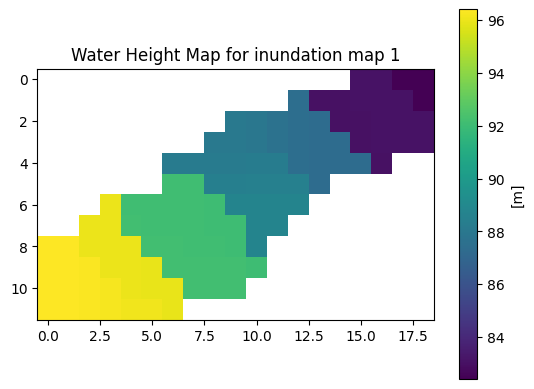

In [28]:
#@title Plot flood extent to depth output
height_raster = flood_extent_to_depth_solve(
    inundation_map=GROUND_TRUTH[0].ground_truth, 
    dem=DEM, 
    scale=30, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=32, 
        solve_iterations_factor=3.,
        force_coeff=0.1,
        drop_iterations=2,
        drop_coeff=0.1),
    force_tolerance=1, 
    force_local_region_width=5)

plt.title('Water Height Map for inundation map 1')
plt.imshow(height_raster)
plt.colorbar(label='[m]')
plt.show()

In [19]:
m = ManifoldModel(
    dem=DEM, 
    scale=30, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=32, 
        solve_iterations_factor=3.,
        force_coeff=0.9,
        drop_iterations=1,
        drop_coeff=0.00003),
    force_tolerance=1, 
    force_local_region_width=5,
    flood_agree_threshold=0)

m.train(minumum_ratios=[0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20],
        ground_truth=GROUND_TRUTH)

Training an inner thresholding model used for flood-fill.
For min_ratio=0.1 we get f1=0.993717033819423
For min_ratio=0.3 we get f1=0.993717033819423
For min_ratio=0.5 we get f1=0.993717033819423
For min_ratio=1 we get f1=0.993717033819423
For min_ratio=2 we get f1=0.9936370777690496
For min_ratio=5 we get f1=0.9936370777690496
For min_ratio=10 we get f1=0.9936370777690496
For min_ratio=15 we get f1=0.9936370777690496
For min_ratio=20 we get f1=0.9936370777690496
chosen min_ratio 1
Running flood extent to depth on ground truth examples..
Running flood extent to depth algorithm for image at gauge_level 5.22
Running flood extent to depth algorithm for image at gauge_level 8.14


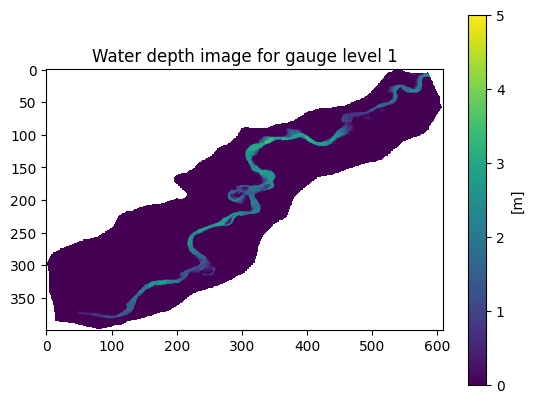

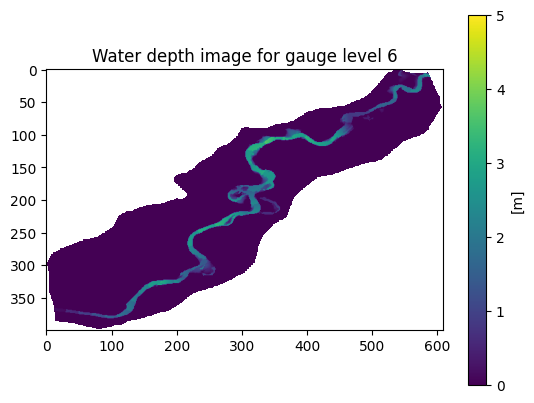

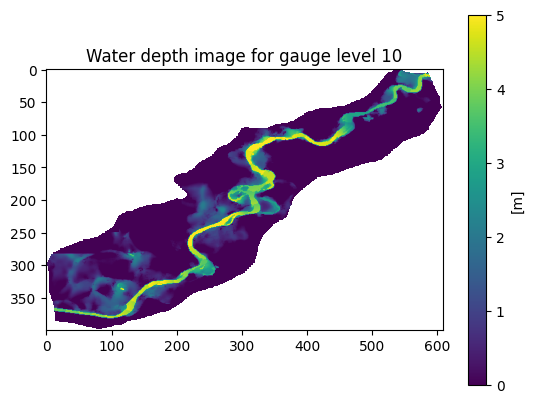

In [23]:
# Manifold interpolation example
for gauge_level in [1, 6, 10]:
    plt.title(f'Water depth image for gauge level {gauge_level}')
    plt.imshow(m.infer(gauge_level), vmin=0, vmax=5)
    plt.colorbar(label='[m]')
    plt.show()


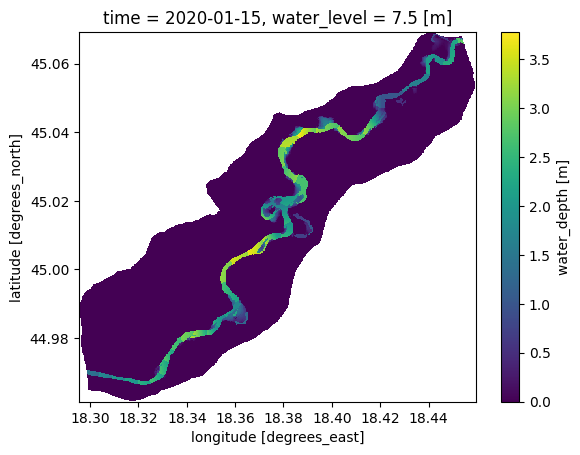

In [24]:
ds_man = generate_wet_dry_timeseries_ds(gauge_levels, timestamps, m, transforms, crs)
ds_man["water_depth"].sel(time="2020-01-15").plot();